# Python Libraries


In [ ]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

2024-12-17 17:45:23.272985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 17:45:23.273121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 17:45:23.392566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Read and Analyse Data

In [ ]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_dir = '/content/drive/MyDrive/tomato/train'
df = loading_the_data(data_dir)

df

filepaths  \
0     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
1     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
2     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
3     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
4     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
...                                                 ...   
9995  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
9996  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
9997  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
9998  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
9999  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   

                                             labels  
0                              Tomato___Late_blight  
1                              Tomato___Late_blight  
2                              Tomato___Late_blight  
3                              Tomato___Late_blight  
4                              Tomato___Late_blight  
...                                             ...  
9995  Tomato___Spider_mites Two-spotted_spider_mite  
9996  Tomato___Spider_mites Two-spotted_spider_mite  
9997  Tomato___Spider_mites Two-spotted_spider_mite  
9998  Tomato___Spider_mites Two-spotted_spider_mite  
9999  Tomato___Spider_mites Two-spotted_spider_mite  

[10000 rows x 2 columns]

In [ ]:
data_balance = df.labels.value_counts()
data_balance

labels
Tomato___Late_blight                             1000
Tomato___healthy                                 1000
Tomato___Early_blight                            1000
Tomato___Septoria_leaf_spot                      1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus           1000
Tomato___Bacterial_spot                          1000
Tomato___Target_Spot                             1000
Tomato___Tomato_mosaic_virus                     1000
Tomato___Leaf_Mold                               1000
Tomato___Spider_mites Two-spotted_spider_mite    1000
Name: count, dtype: int64

In [ ]:
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


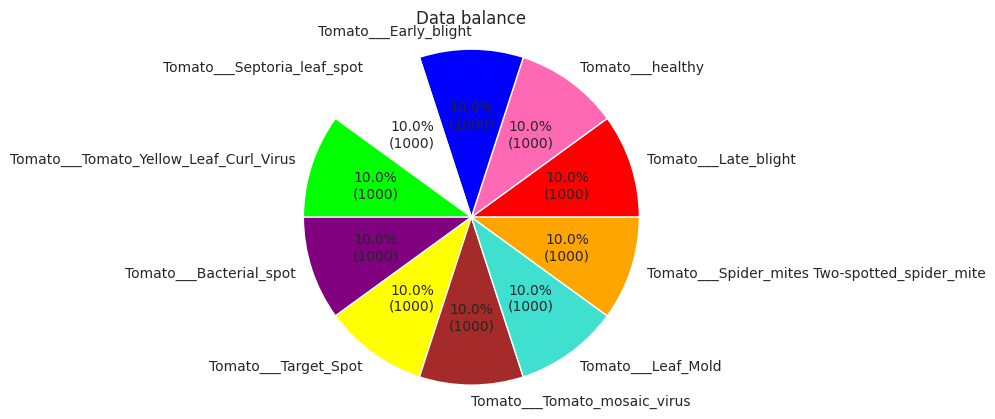

In [ ]:
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#FF0000", "#FF69B4", "#0000FF", "#FFFFFF", "#00FF00", "#800080", "#FFFF00", "#A52A2A", "#40E0D0", "#FFA500"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

# Helper Functions

In [ ]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [ ]:
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred


In [ ]:
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45, fontsize=8)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [ ]:
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block

In [ ]:
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

# Train - Test Split

In [ ]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


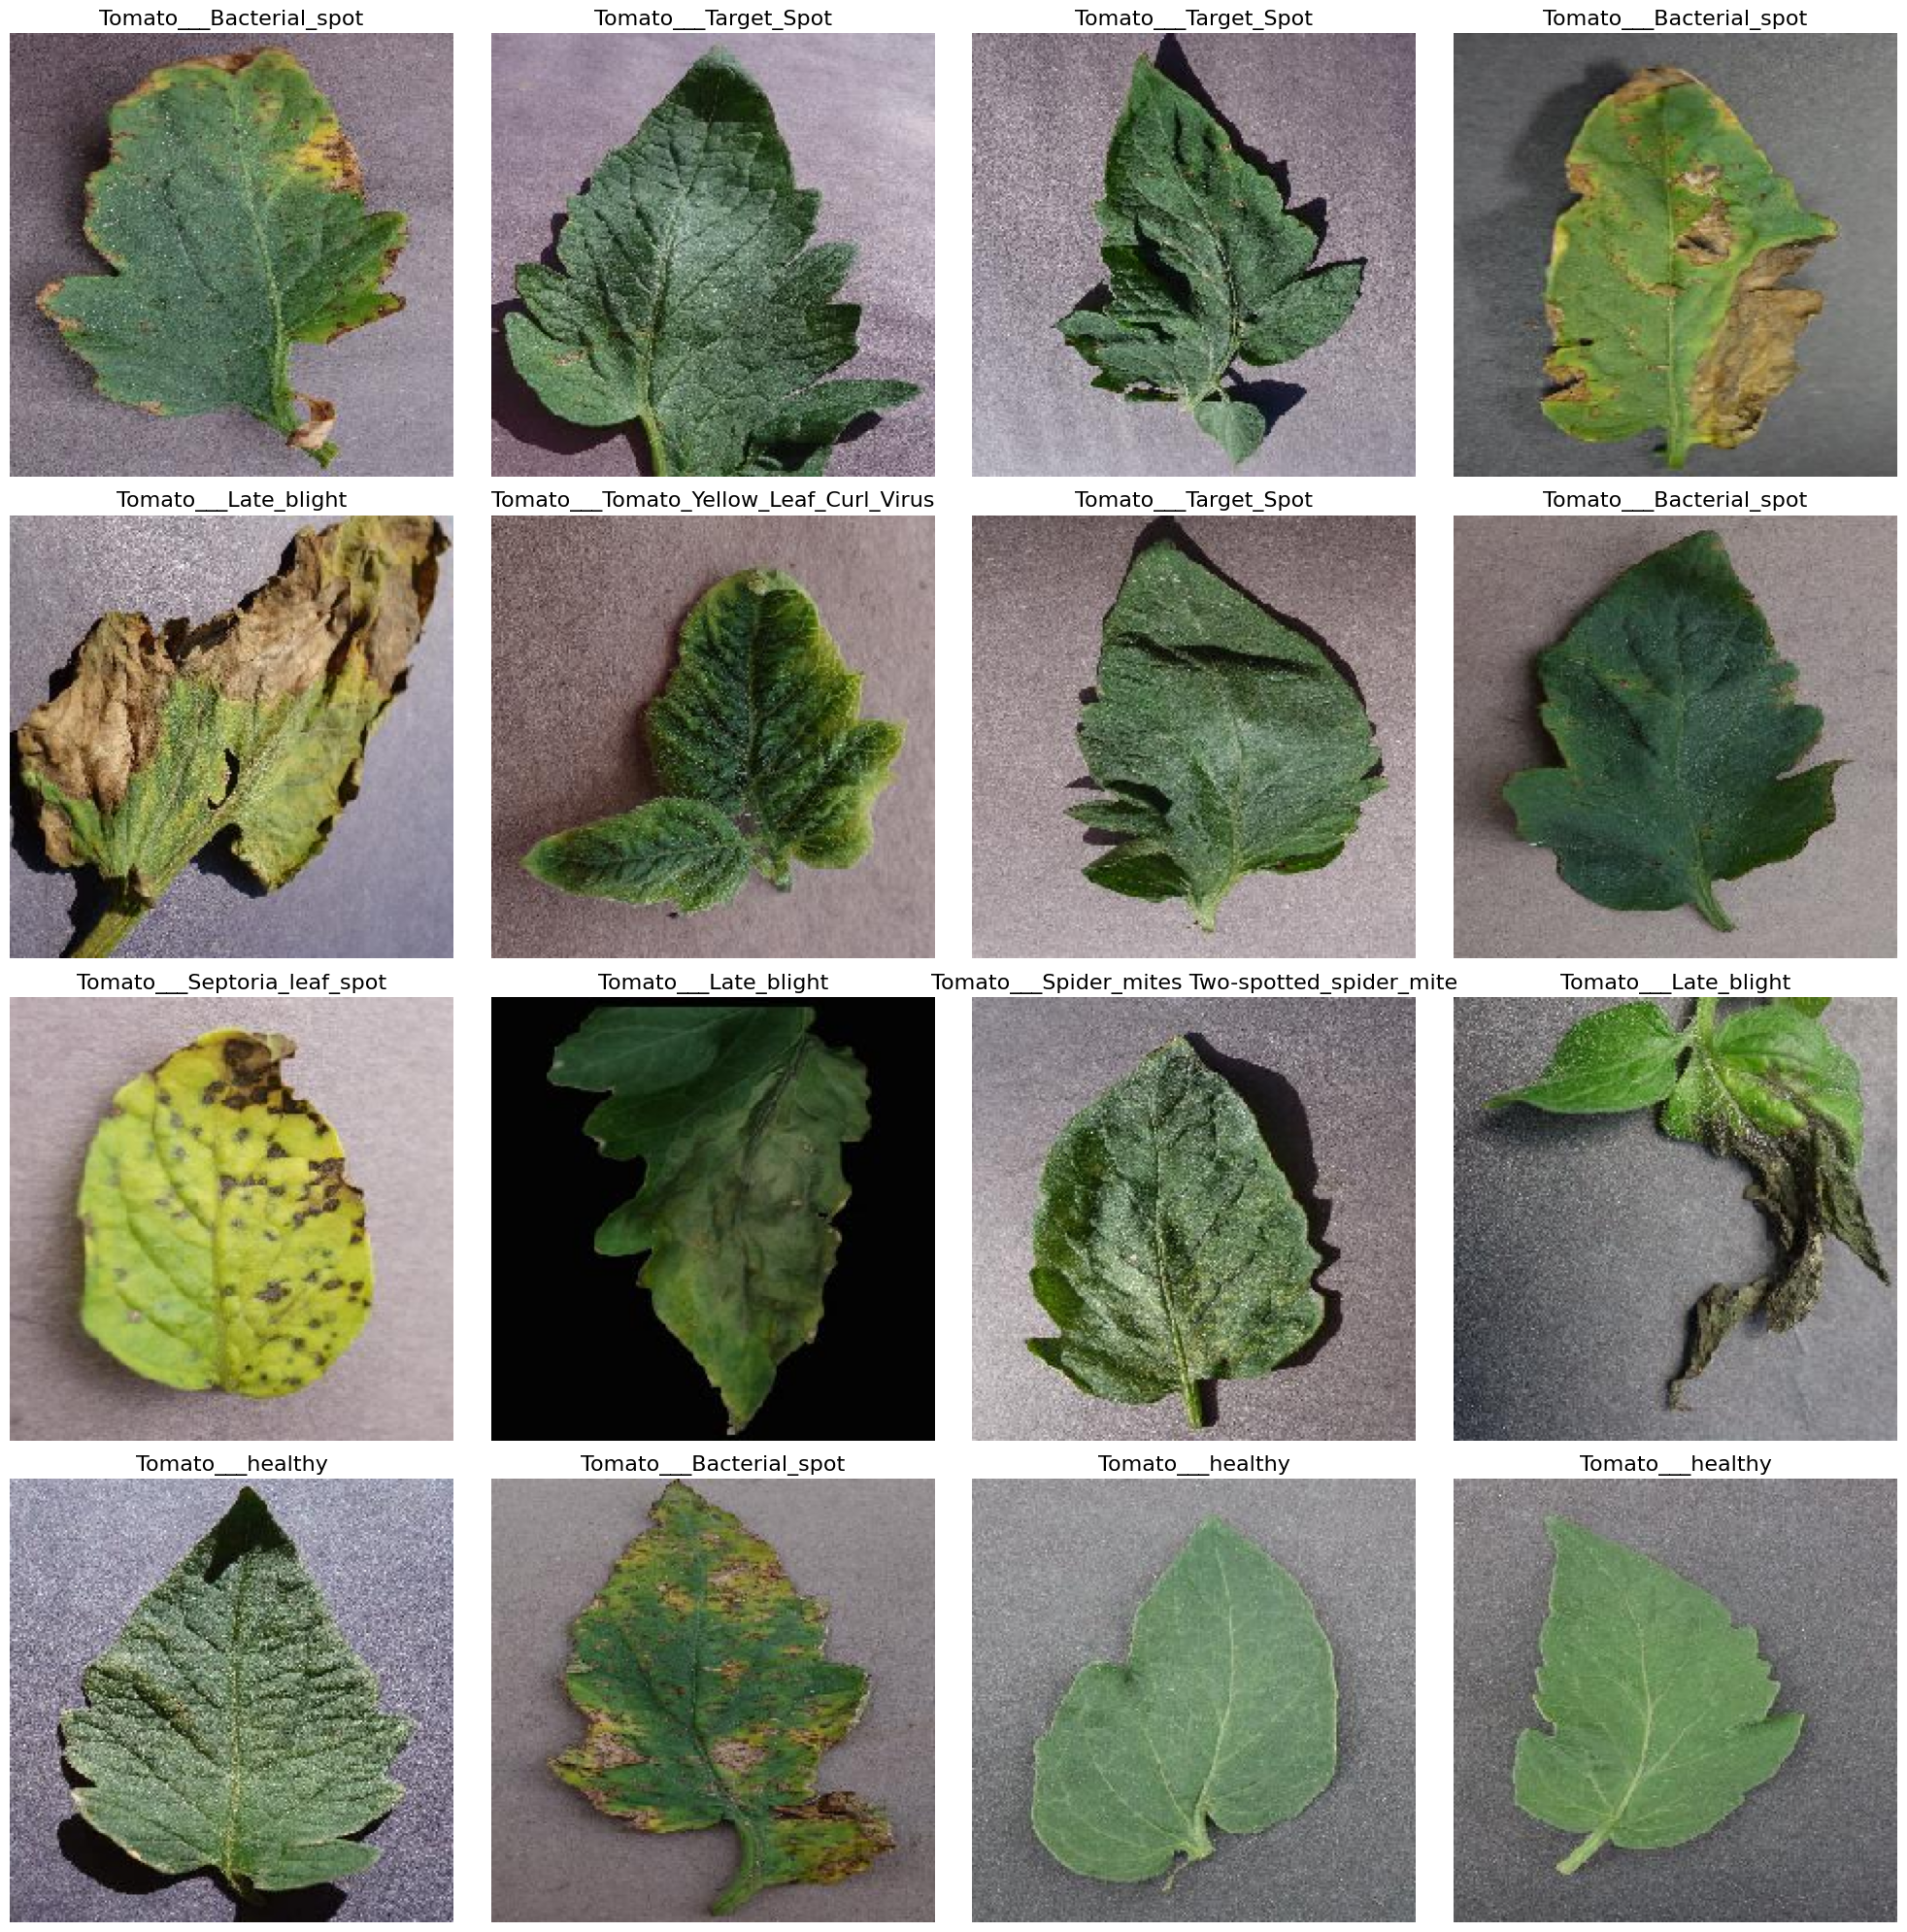

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model Buildings

# CNN Model Building

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

cnn_model.add(conv_block(32))

cnn_model.add(conv_block(64))

cnn_model.add(conv_block(128))

cnn_model.add(conv_block(256))

cnn_model.add(conv_block(512))

cnn_model.add(Flatten())

cnn_model.add(dense_block(256, 0.5))

cnn_model.add(dense_block(128, 0.3))

cnn_model.add(dense_block(64, 0.2))

cnn_model.add(dense_block(32, 0.2))

cnn_model.add(Dense(class_counts, activation = "softmax"))

In [ ]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 3, 3, 512)      │     3,542,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256)            │     1,180,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,945,834 (22.68 MB)

 Trainable params: 5,942,858 (22.67 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [ ]:
epochs = 22

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/22
  2/500 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.0625 - loss: 3.4329   

I0000 00:00:1734457572.964155      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1734457572.987805      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1735 - loss: 2.5675

W0000 00:00:1734457617.550702      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 105ms/step - accuracy: 0.1736 - loss: 2.5669 - val_accuracy: 0.1990 - val_loss: 2.3387
Epoch 2/22
  3/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.3576 - loss: 1.9747

W0000 00:00:1734457625.562467      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.3533 - loss: 1.8271 - val_accuracy: 0.5510 - val_loss: 1.2906
Epoch 3/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.4534 - loss: 1.5551 - val_accuracy: 0.6440 - val_loss: 1.0310
Epoch 4/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5411 - loss: 1.3151 - val_accuracy: 0.7300 - val_loss: 0.8112
Epoch 5/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6071 - loss: 1.1383 - val_accuracy: 0.6840 - val_loss: 0.9661
Epoch 6/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.6656 - loss: 1.0233 - val_accuracy: 0.7280 - val_loss: 0.8529
Epoch 7/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.6788 - loss: 0.9715 - val_accuracy: 0.7680 - val_loss: 0.6454
Epoch 8/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7463 - loss: 0.7792 - val_accuracy: 0.7700 - val_loss: 0.6332
Epoch 9/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7699 - loss: 0.7509 - val_accurac

# CNN Model Performance - Prediction

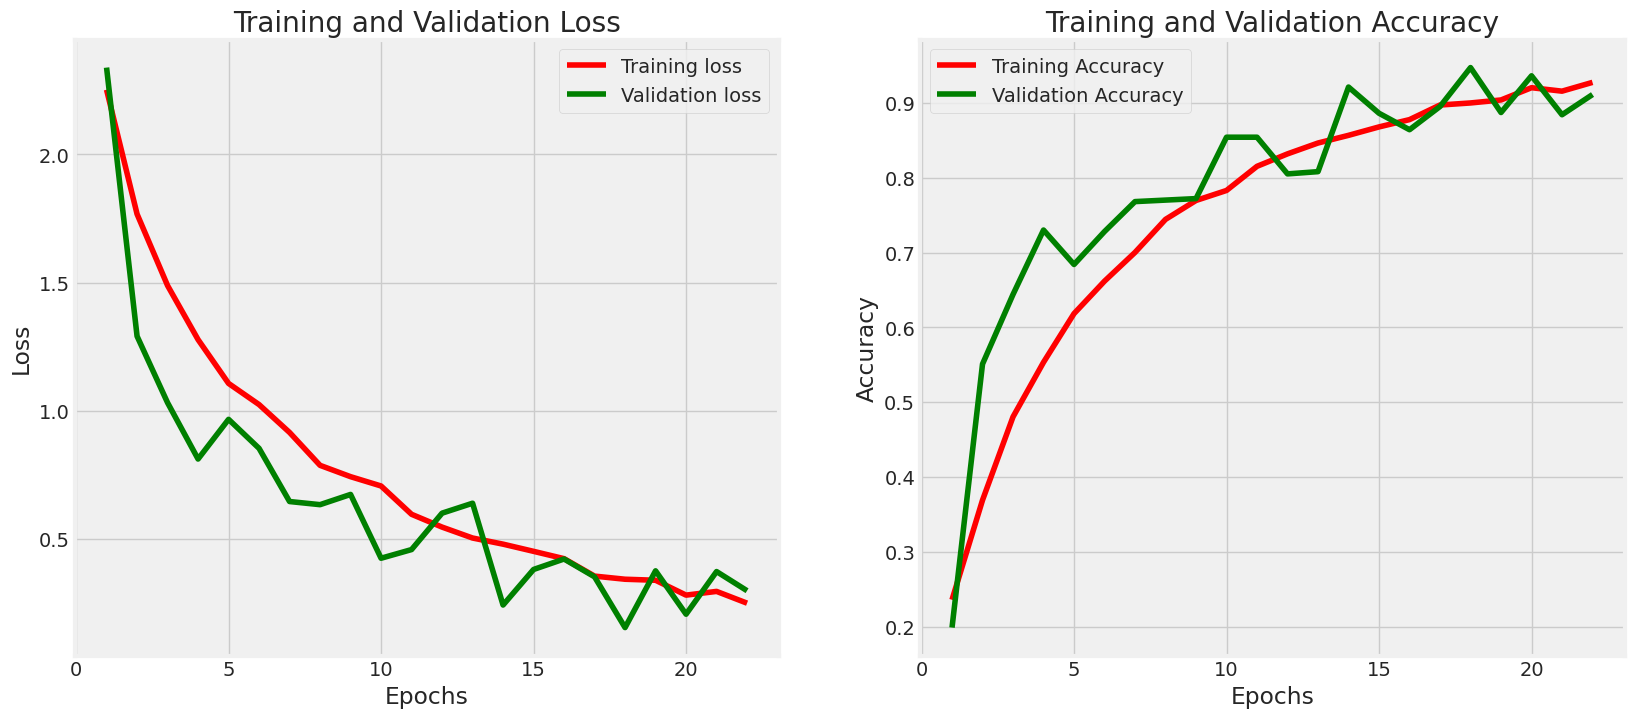

In [ ]:
model_performance(history, epochs)

In [ ]:
model_evaluation(cnn_model)

500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9458 - loss: 0.1617
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9137 - loss: 0.2895
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.8892 - loss: 0.3580
Train Loss:  0.15702921152114868
Train Accuracy:  0.9473749995231628
--------------------
Validation Loss:  0.291491836309433
Validation Accuracy:  0.9110000133514404
--------------------
Test Loss:  0.33873364329338074
Test Accuracy:  0.8939999938011169


 8/63 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

W0000 00:00:1734458068.262168      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


W0000 00:00:1734458070.909254      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


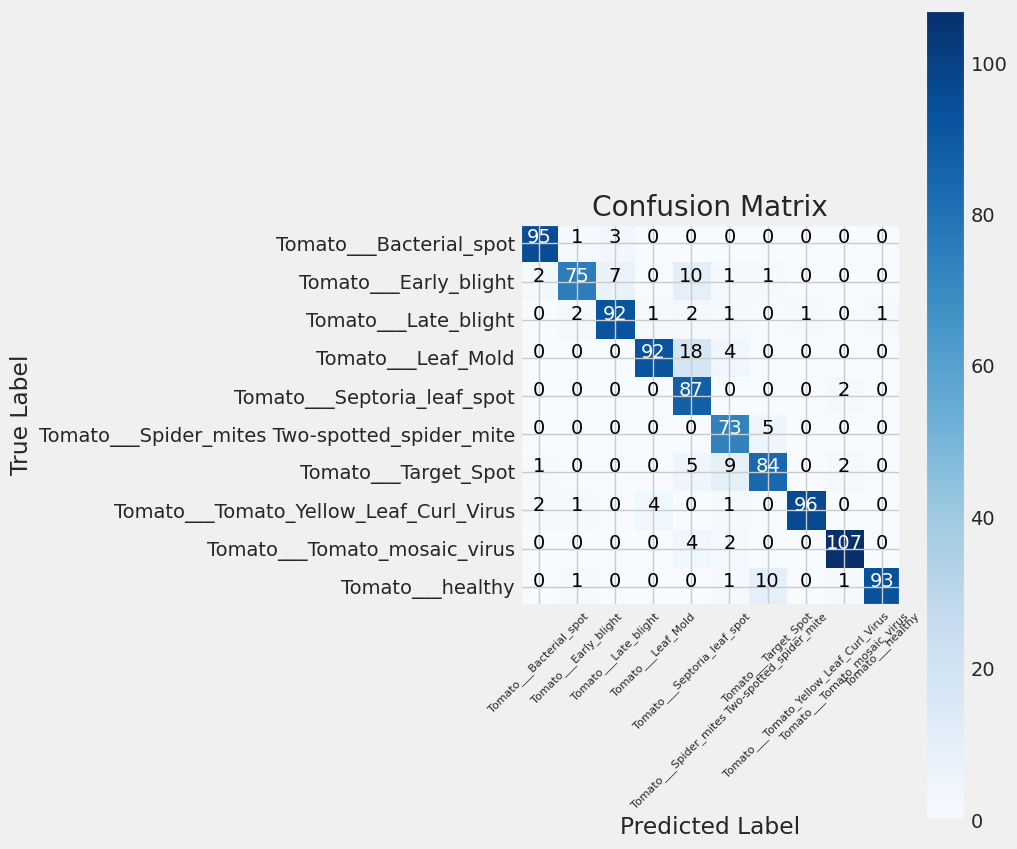

In [ ]:
y_pred = get_pred(cnn_model, test_gen)

plot_confusion_matrix(test_gen, y_pred)

# EfficientNetB3 Model Building

In [ ]:

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation


EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,513 (41.93 MB)

 Trainable params: 10,900,818 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [ ]:
epochs = 22

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/22
  1/500 ━━━━━━━━━━━━━━━━━━━━ 19:57:07 144s/step - accuracy: 0.1250 - loss: 2.8150

W0000 00:00:1734458218.461934      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2261 - loss: 2.4538

W0000 00:00:1734458303.361519      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 240s 192ms/step - accuracy: 0.2263 - loss: 2.4532 - val_accuracy: 0.1660 - val_loss: 2.4590
Epoch 2/22


W0000 00:00:1734458314.509099      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 159ms/step - accuracy: 0.5194 - loss: 1.4354 - val_accuracy: 0.7990 - val_loss: 0.7665
Epoch 3/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - accuracy: 0.6678 - loss: 1.0336 - val_accuracy: 0.8820 - val_loss: 0.5291
Epoch 4/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 157ms/step - accuracy: 0.7770 - loss: 0.7825 - val_accuracy: 0.9230 - val_loss: 0.3728
Epoch 5/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - accuracy: 0.8183 - loss: 0.6491 - val_accuracy: 0.9490 - val_loss: 0.2799
Epoch 6/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 157ms/step - accuracy: 0.8709 - loss: 0.5197 - val_accuracy: 0.9600 - val_loss: 0.2161
Epoch 7/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - accuracy: 0.9079 - loss: 0.4220 - val_accuracy: 0.9680 - val_loss: 0.1777
Epoch 8/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - accuracy: 0.9087 - loss: 0.3758 - val_accuracy: 0.9770 - val_loss: 0.1398
Epoch 9/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 157ms/step - accuracy: 0.9386 - loss: 0.3164 - val

# EfficientNetB3 Model Performance - Prediction

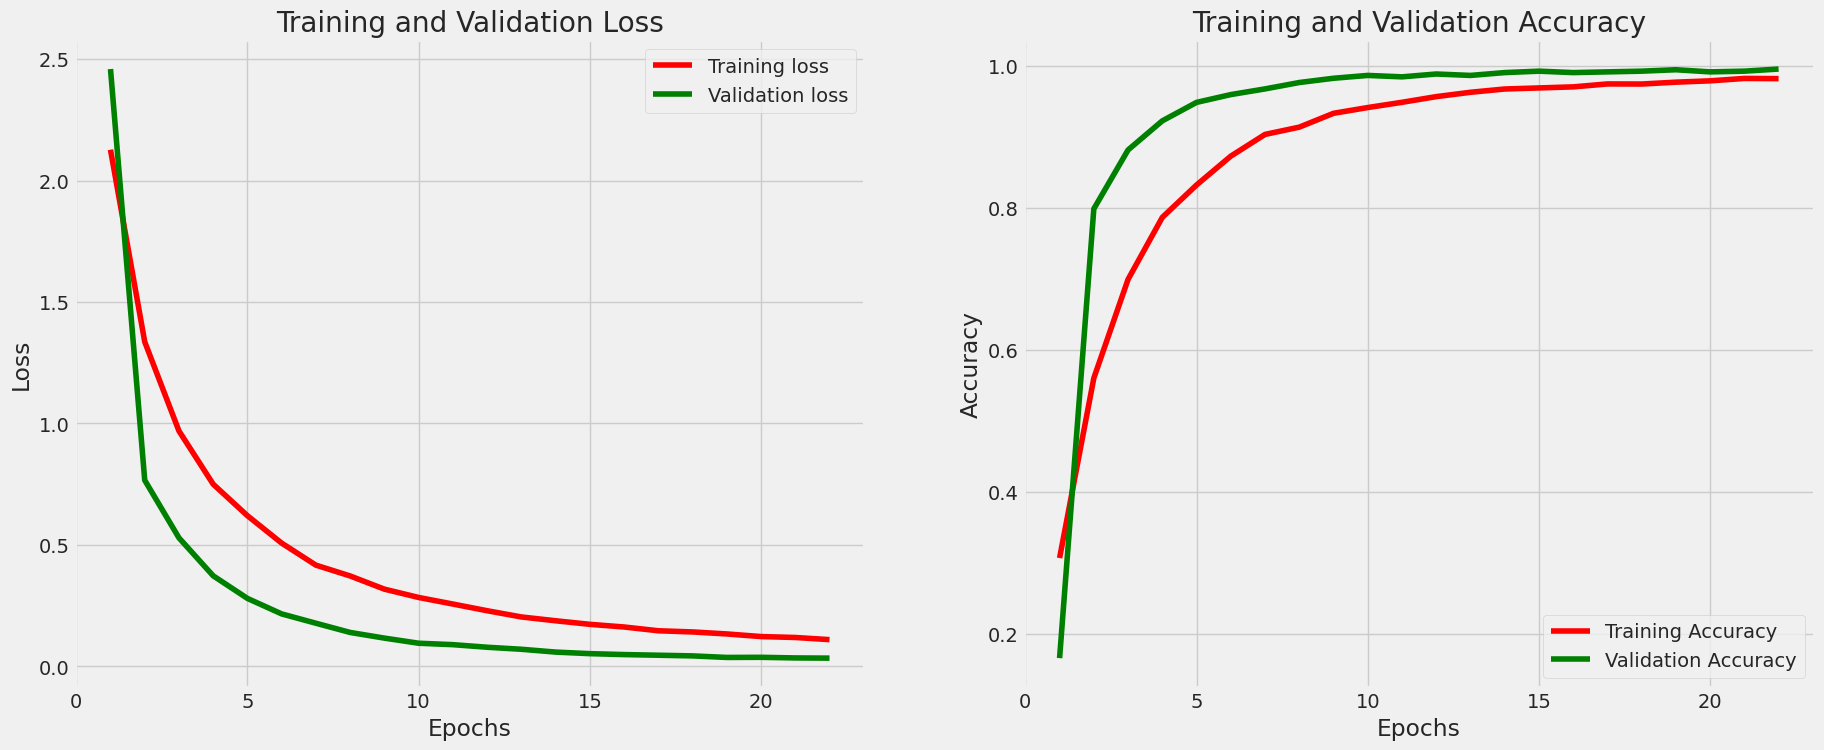

In [ ]:
model_performance(EfficientNetB3_history, epochs)

In [ ]:
model_evaluation(EfficientNetB3_model)

500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 1.0000 - loss: 0.0111
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9956 - loss: 0.0356
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9902 - loss: 0.0404
Train Loss:  0.0110108507797122
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0329284630715847
Validation Accuracy:  0.9959999918937683
--------------------
Test Loss:  0.047271035611629486
Test Accuracy:  0.9919999837875366


 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step

W0000 00:00:1734460003.939495      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step


W0000 00:00:1734460013.809126      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


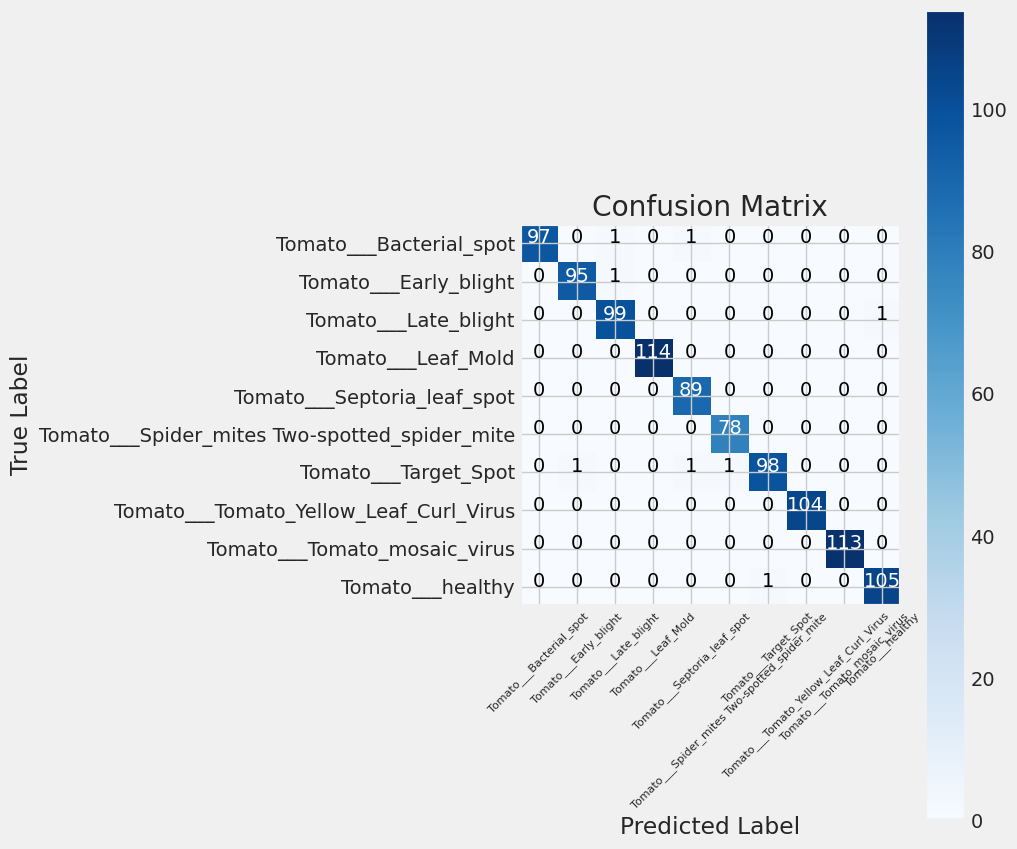

In [ ]:
y_pred = get_pred(EfficientNetB3_model, test_gen)


plot_confusion_matrix(test_gen, y_pred)

# VGG16 Model Building

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

for layer in base_model.layers[:15]:
    layer.trainable = False



x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   # # Dropout layer to prevent overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation


VGG16_model = Model(inputs = base_model.input, outputs = predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in VGG16_model.layers:
    print(layer.name, layer.trainable)

input_layer_13 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_max_pooling2d True
flatten_1 True
dense_8 True
dropout_6 True
dense_9 True
dense_10 True
dense_11 True
dense_12 True


In [ ]:
VGG16_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,146,026 (57.78 MB)

 Trainable params: 7,510,762 (28.65 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
epochs = 22

VGG16_history = VGG16_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 131ms/step - accuracy: 0.3040 - loss: 0.3380 - val_accuracy: 0.6470 - val_loss: 0.1756
Epoch 2/22
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:06 133ms/step - accuracy: 0.5625 - loss: 0.1808

W0000 00:00:1734460105.780797      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 105ms/step - accuracy: 0.6927 - loss: 0.1632 - val_accuracy: 0.7830 - val_loss: 0.1192
Epoch 3/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 104ms/step - accuracy: 0.8142 - loss: 0.1100 - val_accuracy: 0.8690 - val_loss: 0.0803
Epoch 4/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 104ms/step - accuracy: 0.8916 - loss: 0.0752 - val_accuracy: 0.8450 - val_loss: 0.0917
Epoch 5/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.9219 - loss: 0.0553 - val_accuracy: 0.9020 - val_loss: 0.0561
Epoch 6/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.9520 - loss: 0.0382 - val_accuracy: 0.9320 - val_loss: 0.0419
Epoch 7/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.9642 - loss: 0.0276 - val_accuracy: 0.9440 - val_loss: 0.0341
Epoch 8/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.9778 - loss: 0.0210 - val_accuracy: 0.9430 - val_loss: 0.0341
Epoch 9/22
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.9813 - loss: 0.0167 - val

# VGG16 Model Performance - Prediction

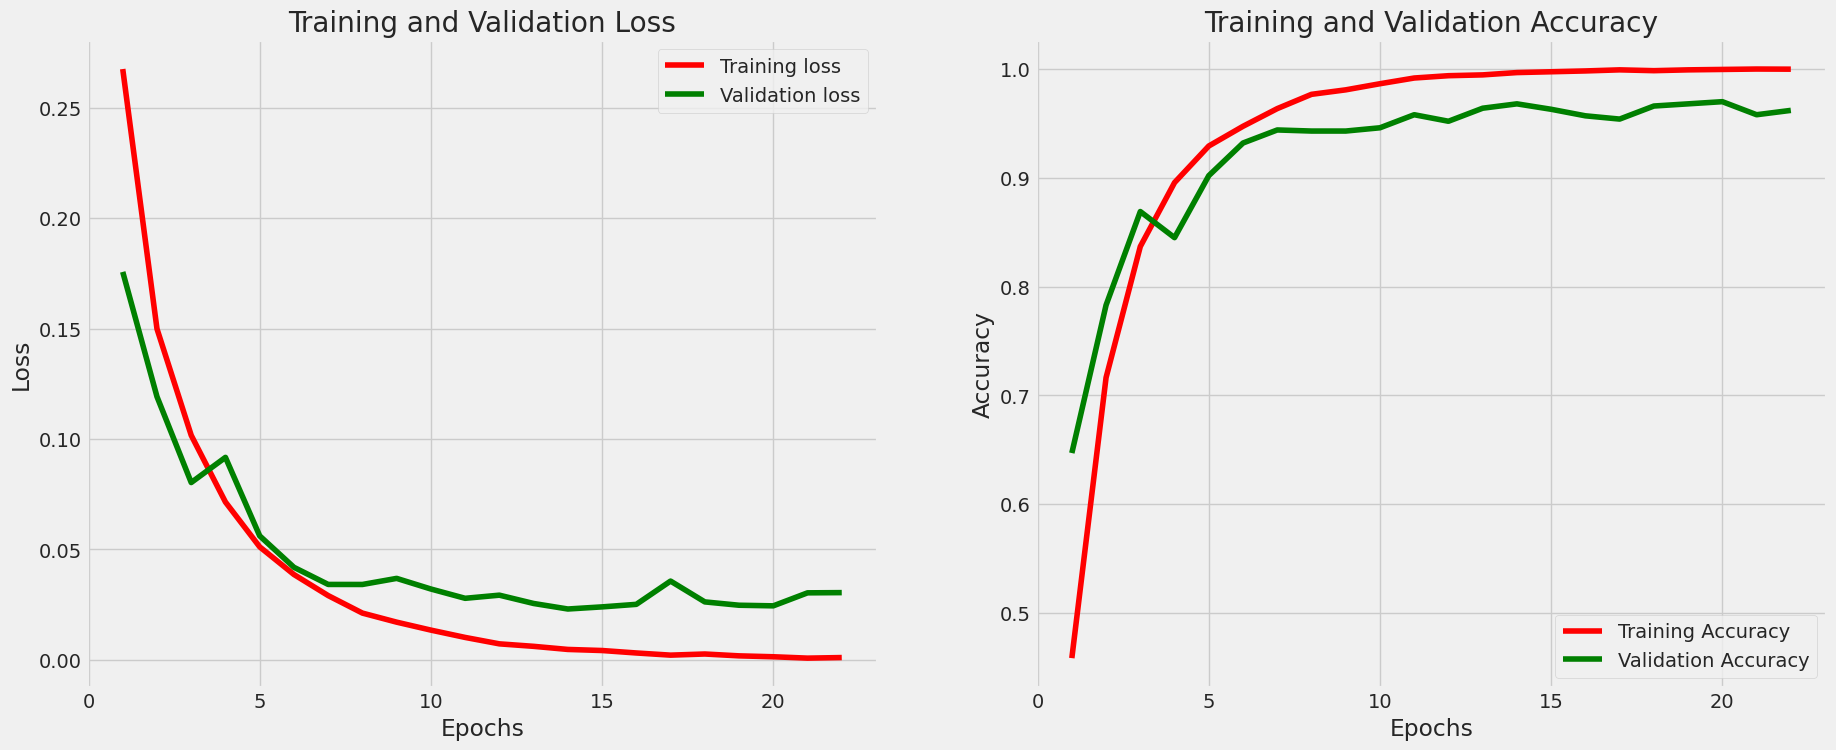

In [ ]:
model_performance(VGG16_history, epochs)

In [ ]:
model_evaluation(VGG16_model)

500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 1.0000 - loss: 2.0627e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9595 - loss: 0.0345
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9358 - loss: 0.0433
Train Loss:  0.00023434095783159137
Train Accuracy:  1.0
--------------------
Validation Loss:  0.031076479703187943
Validation Accuracy:  0.9620000123977661
--------------------
Test Loss:  0.04325331002473831
Test Accuracy:  0.9470000267028809


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


W0000 00:00:1734461263.989485      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


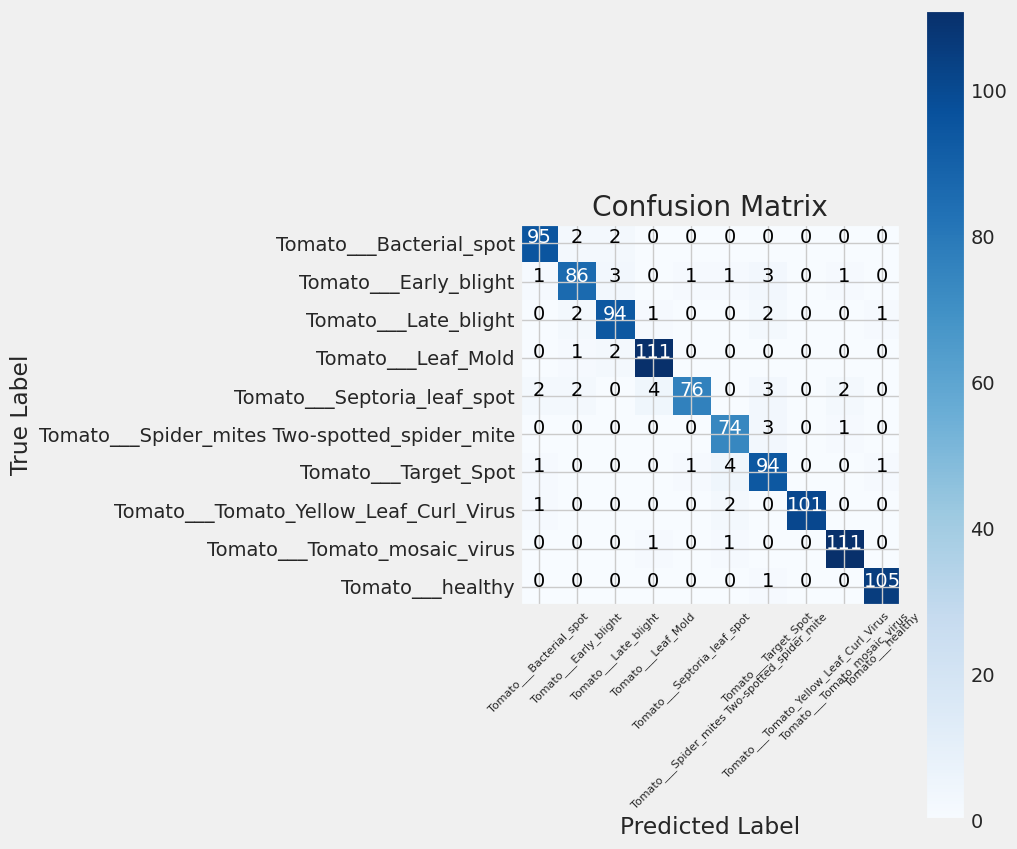

In [ ]:
y_pred = get_pred(VGG16_model, test_gen)

plot_confusion_matrix(test_gen, y_pred)